# Assignment 3: Unsupervised Learning

In this assignment you will:
* Implement K-means clustering and use it for color-quantization of images
* Train a MoG model by implementing the EM algorithm. Compare to K-means on the same test data. 
* Use MoG for image segmentation
* Get familiar with spectral clustering

# Part 1: K-Means Clustering

## Setup

First import the required packages and do some setup:

In [15]:
from __future__ import print_function

import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import imageio
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles
from scipy.stats import multivariate_normal
from assignment3 import kmeans, kmeans_colors, spectral_clustering, em_mog, em_segmentation

# Set default parameters for plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Let's generate some test-data for you to test your implementation of the k-means and EM algorithm. Note that we generate gaussian blobs with non-isotropic covariance matrices. 

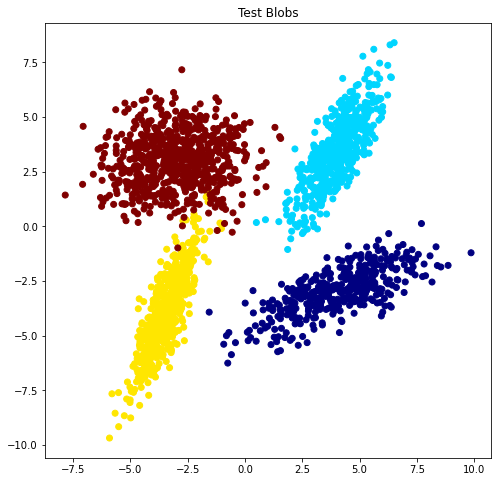

In [16]:
# Generate samples of 4 different gaussians
rv1 = multivariate_normal.rvs([4.0, -3.], [[4.0, 1.5], [1.5, 1.1]], size=400)
rv2 = multivariate_normal.rvs([4.0, 3.5], [[1.0, 1.3], [1.3, 2.75]], size=500)
rv3 = multivariate_normal.rvs([-3.5, -4.0], [[0.5, 1.0], [1.0, 3.]], size=600)
rv4 = multivariate_normal.rvs([-3., 3.], [[2.5, 0.1], [0.1, 1.5]], size=700)

# Concatenate the samples and create corresponding labels
X = np.concatenate([rv1, rv2, rv3, rv4], 0)
y = np.array([0]*400+[1]*500+[2]*600+[3]*700)

# Plot the test data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Test Blobs")
plt.show()

## Exercise 1: K-Means Clustering [20 Points]

You will now implement the standard k-means clustering algorithm and test it on the generated test data. 

**TODO**: Implement the k-means clustering algorithm in ***kmeans.py*** accroding to specs and test your implementation with the provided test data.


In [17]:
def plot_clusters(X, num_clusters, clustering_algorithm):
    centers, assign = clustering_algorithm(X, num_clusters)
    plt.clf()
    plt.scatter(X[:, 0], X[:, 1], c=assign)
    plt.scatter(centers[:, 0], centers[:, 1], c='r', marker='x')
    plt.title("Predicted clustering")
    plt.show()

Number of iterations: 7, Execution time: 0.6362051963806152s


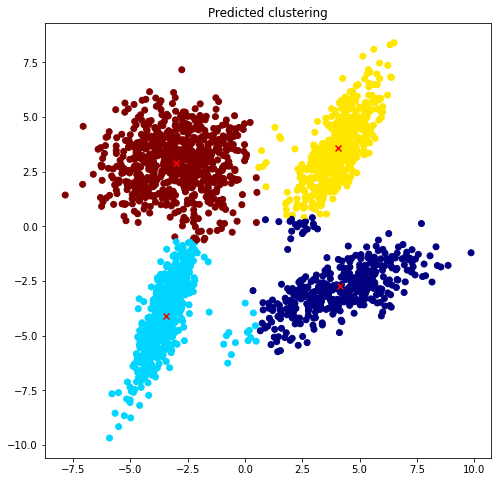

In [18]:
# Test your implementation
plot_clusters(X, 4, kmeans)

## Exercise 2: Questions about K-means [10 Points]

* Does k-means always result in the same clustering? Why?

***Your Answer:***
No, K-means finds a local optima, depending of the initial centers. Imagine a symmetric case in $\mathbb{R}^{2}$ with 4 data points in the corners of a square. Depending on the starting centers, the 4 points are clustered vertically or horizontally. If the initial centers do not change, then of course k-means results in the same clustering.  

* Would you expect K-means to work better in the case of data generated from isotropic gaussian distributions? Why?

***Your Answer:***
Isortopic means the covariance Matrix is $\sigma^2$ x Id which results in clusters alligned with axes and even cirlce shape. This has no effect, because in both cases one can immagine the data easy or difficult to cluster. It depends on whether the data is more or less disjoint with rather small variance and centers appart, and not on the orientation. The brown blob is close to isotrocpic, thus no advantage visible here. 

## Exercise 3: Using k-means for image compression [15 Points]

You will now use K-means to cluster pixel values of an image and use the cluster assignments as a way to quantize/compress the color-space of the image. Replace each pixel with the mean of the assigned cluster.
You should use the implementation provided through sklearn in this exercise ([sklearn.cluster.KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)).

Feel free to test the algorithm on your own images and with different number of clusters.

**TODO**: Implement the color-quantization through k-means in ***kmeans_colors.py*** according to specs. 


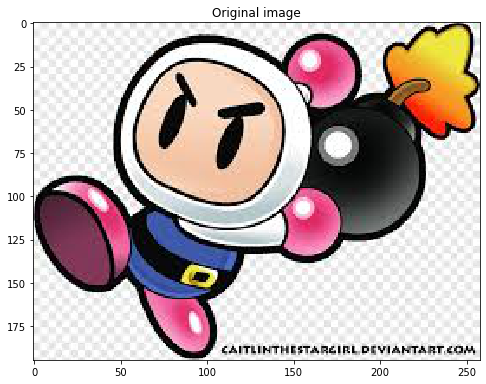

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


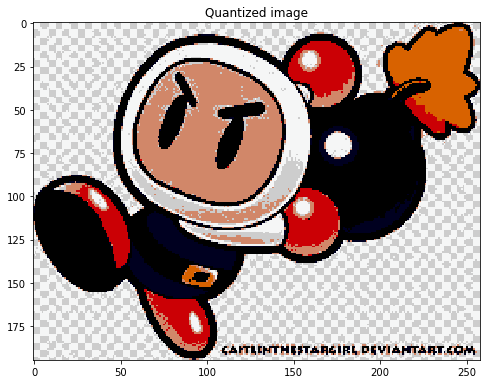

In [19]:
# Load and show test image
img = imageio.imread('bomberman.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute quantized image
k = 8
img_cl = kmeans_colors(img, k)

# Show the quantized image
plt.imshow(img_cl)
plt.title("Quantized image")
plt.show()

# Part 2: Expectation Maximization

In the second part of the assignment you will implement the EM algorithm for Mixture of Gaussian (MoG) models. You will then use this model on the problem of image-segmentation.


## Exercise 4: EM for MoG [30 Points]

**TODO:** Implement the **EM** algorithm for Mixture of Gaussian models in **em_mog.py** according to specs. Test your implementation on the provided test data.  

Iter: 1/20, LL: -9617.378806919925
Iter: 2/20, LL: -9615.028706769688
EM has converged...
Number of iterations: 2, Execution time: 12.064112663269043s


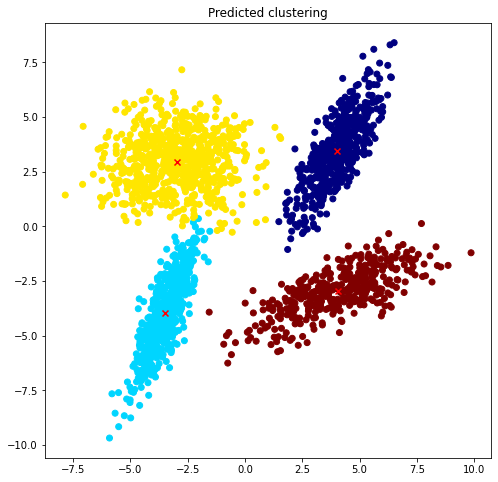

In [20]:
# Test your implementation
phi, mu, sigma, w = em_mog(X, 4)
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=np.argmax(w, 1))
plt.scatter(mu[:, 0], mu[:, 1], c='r', marker='x')
plt.title("Predicted clustering")
plt.show()


## Exercise 5: Questions about MoG [10 Points]

* Does the MoG model perform better on the provided test data? Why?

***Your Answer:***
The test data is Normal distributed, thus the MoG assumption matches perfectly, thus MoG performs very well on the test data. Observing the clustering of kmeans in the exercise above shows not perfectly matched clusters, few data points are assigned to the wrong cluster, at least what I can see by myself.

* What are advantages and disantages of MoG vs. K-means?

***Your Answer:***
As seen, k-Means only finds a local minimum depending on the starting centers. This might be seen as a disadvantage. One solution to this is to apply k-Means several time to randomly selected initial centers and then choose the minima. 
MoG assumes the distribution around centers is Normal. This might not ne the case on many datasets thus MoG performs not well under those conditions.
k-Means also works same independet of the site of the data, whether MoG needs a certain number of data points per cluster to have a suitable distribution. Thus MoG not suitable for only few data points or a high number of clusters compared with the size of the data.


## Exercise 6: Image Segmentation with MoG [15 Points]

Image segmentation is the process of partitioning an image into multiple segments. The goal of segmentation is to simplify and/or change the representation of an image into something that is more meaningful and easier to analyze.

In this exercise you will implement image segmentation by fitting a MoG model via EM. For this you will not only cluster the pixel colors (RGB) but extend the pixel features with their 2D coordinates. Hence, the clustered pixel features are of the form RGBXY. This allows for additional locality of the segments.

You should use the implementation provided through sklearn in this exercise ([sklearn.mixture.GaussianMixture](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html)).

Feel free to test the algorithm on your own images and with different number of segments.

**TODO:** Implement the image-segmentation in ***em_segmentation.py*** according to specs.  

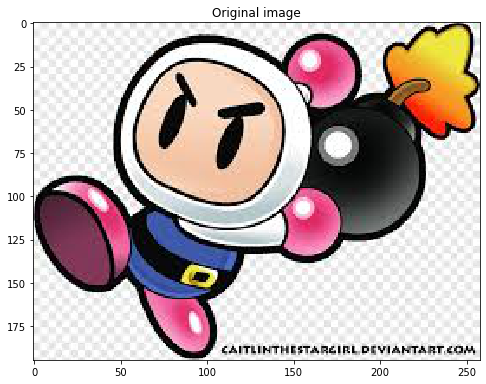

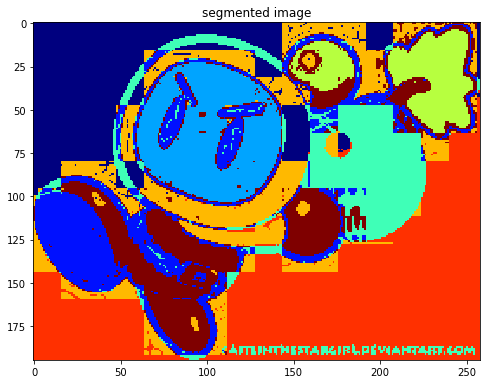

In [22]:
# Load and show test image
img = imageio.imread('Bomberman.jpg')
plt.imshow(img)
plt.title("Original image")
plt.show()

# Compute segmented image
img_seg = em_segmentation(img, 8)
plt.imshow(img_seg)
plt.title("segmented image")
plt.show()

## Bonus: Spectral clustering [15 points]

In some cases the structure of the data itself makes it difficult for algorithms like K-means to work. Can you think of some cases, when K-means will not work?

In this section we will generate such kind of data.

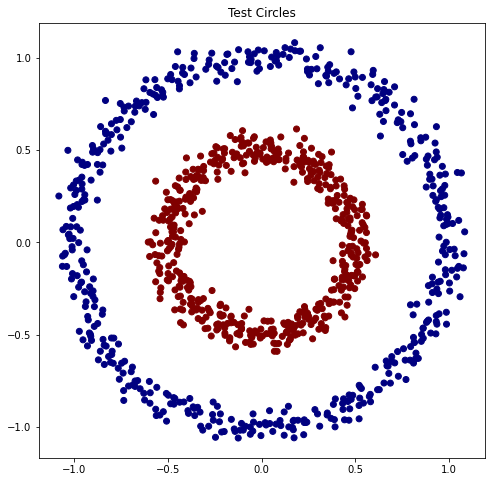

In [28]:
X, y = make_circles(n_samples=1000, factor=0.5, noise=0.05)

# Plot test data
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.title("Test Circles")
plt.show()

Let us try apply K-means clustering at first.

Number of iterations: 9, Execution time: 0.13147759437561035s


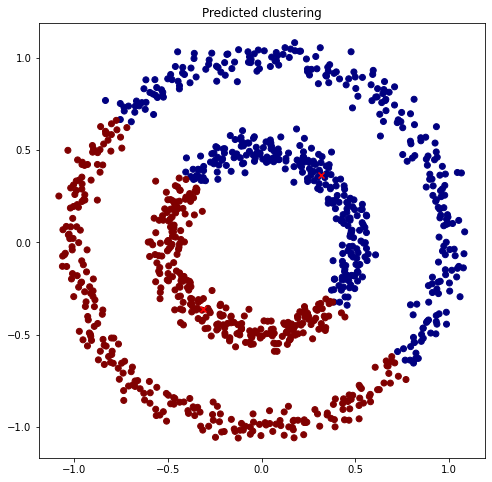

In [29]:
plot_clusters(X, 2, kmeans)

K-means clearly doesn't work in this case. However there exist some algorithms, that can deal with such data structure. One of them is **spectral clustering**. 

In every clustering algorithm the starting point is a $N$ x $N$ matrix of pairwise similarities $s_{ij} > 0, \; i, j = 1 \dots N$. For **spectral clustering** we will use the radial-kernel gram matrix as similarities matrix, i.e. $$s_{ij} = \exp\left(\frac{-d_{ij}^2}{c}\right),$$ where $d_{ij}$ is the Euclidian distance between $x_i$ and $x_j$, and $c > 0$ is a scale parameter.

Besides this, we will assign a fully connected weighted graph to the data with nodes $v_i$ at data points and edge weights equal to $w_{ij} = s_{ij}$. A $N$ x $N$ matrix of edge weights $W = \{w_{ij}\}$ is called *adjacency matrix*. The *degree* of node $v_i$ is $g_i = \sum_{j} w_{ij}$. Let $G$ be a diagonal matrix with diagonal elements $g_i$.

Finally, the *graph Laplacian* is defined by $$L = G - W$$

Spectral clustering finds the $m$ eigenvectors $Z_{N x m}$ corresponding o the $m$ smallest eigenvalues of $L$ (ignoring the trivial constant eigenvector). Using K-means we then cluster the rows of $Z_{N x m}$ to yield a clustering of the original data.

For those who want to learn why this works we suggest reading https://web.stanford.edu/~hastie/ElemStatLearn/ (pg. 544)

**TODO:** Implement the **spectral clustering** algorithm in **spectral_clustering.py** accroding to specs and test your implementation with the provided test data.

In [30]:
Z, assign = spectral_clustering(X, 2)

Execution time: 7.281398773193359s


Let us plot the selected eigenvectors

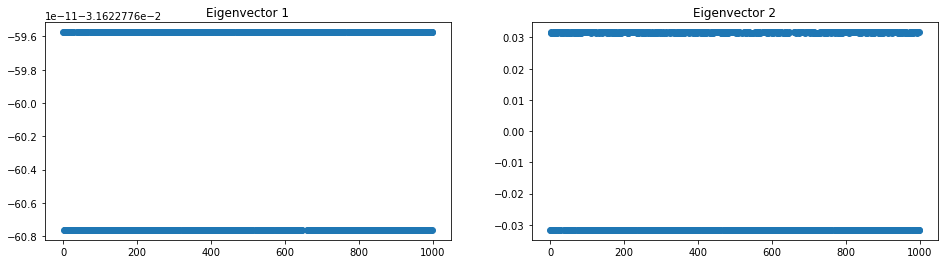

In [31]:
first_eigenvector = Z[:, 0]
second_eigenvector = Z[:, 1]

plt.figure(figsize=(16, 4))
for i, v in enumerate([first_eigenvector, second_eigenvector]):
    plt.subplot(1, 2, i + 1)
    plt.scatter(np.arange(v.size), v)
    plt.title("Eigenvector {}".format(i + 1))

Finally, let us plot the resulting clusters

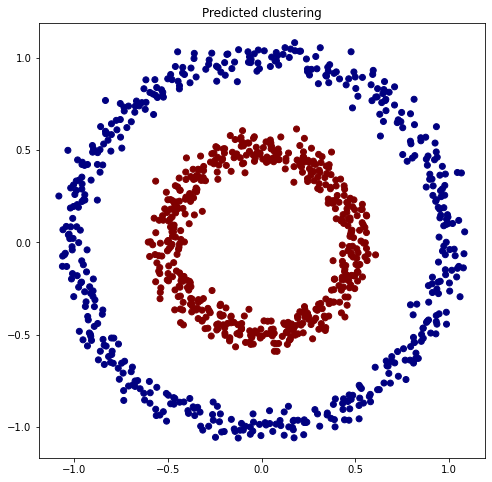

In [32]:
plt.clf()
plt.scatter(X[:, 0], X[:, 1], c=assign)
plt.title("Predicted clustering")
plt.show()
